In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import regions
from regions import Regions
from astropy.coordinates import search_around_sky
from dust_extinction.averages import CT06_MWGC
from scipy.spatial import KDTree
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel
from astropy.convolution import convolve, convolve_fft
from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
from jwst_plots import JWSTCatalog
from jwst_plots import make_cat_use
import cutout_manager as cm

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [5]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

# Load Catalog

In [6]:
cat_use = make_cat_use()

In [7]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

In [8]:
(l*w).to(u.deg**2)*2.3*10**22*u.cm**(-2)#*(3.197442031750E-03*u.deg*5*u.kpc).to(u.cm, u.dimensionless_angles())**2
Area = (l*w*(5*u.kpc)**2).to(u.deg**2*u.cm**2).to(u.cm**2, u.dimensionless_angles())
((Area*2.3*10**22*u.cm**(-2))*2.8*u.u).to(u.Msun)

<Quantity 6779.96324558 solMass>

In [9]:
cutout_405 = cm.get_cutout_405(pos, w, l)
ww = cutout_405.wcs
data_405 = cutout_405.data
pixel_scale = ww.proj_plane_pixel_scales()[0] * u.deg.to(u.arcsec)


In [10]:
pixel_resolution = ww.proj_plane_pixel_scales()[0].to(u.arcsec)
pixel_resolution

<Quantity 0.03123675 arcsec>

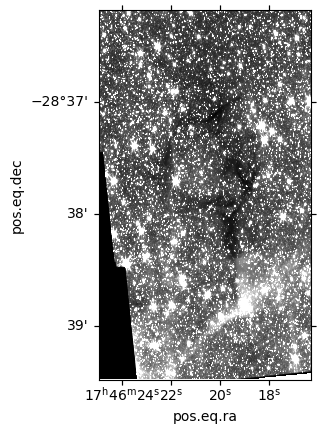

In [11]:
ax = plt.subplot(projection=ww)
ax.imshow(data_405, origin='lower', cmap='gray', vmin=0, vmax=50)
#reg.to_pixel(ww).plot(edgecolor='red')


In [12]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], ww))

# New Extinction Map

In [13]:
#from scipy.spatial import KDTree
#kdtr = KDTree(data)
#seps, inds = kdtr.query(data, k=[2])

In [14]:
pixcoords = ww.all_world2pix(cat_filament.coords.ra, cat_filament.coords.dec, 0)
data = np.array(pixcoords).T

In [15]:
kdtr = KDTree(data)
seps, inds = kdtr.query(data, k=[2])

In [16]:
# Get the pixel scale in arcseconds per pixel
pixel_scale = ww.proj_plane_pixel_scales()[0] * u.deg.to(u.arcsec)

# Convert seps from pixels to arcseconds
seps_arcsec = seps * pixel_scale
seps_arcsec

<Quantity [[0.30574317],
           [0.67210664],
           [0.20522477],
           ...,
           [0.31383396],
           [0.09271932],
           [0.10366585]] deg>

Text(0, 0.5, 'Number of sources')

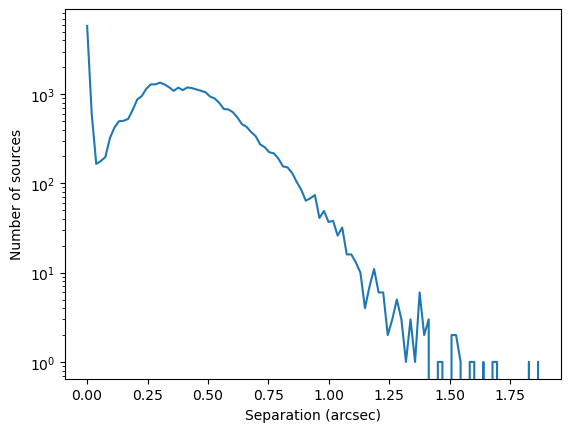

In [17]:
h = np.histogram(seps_arcsec, bins=100)
plt.plot(h[1][:-1], h[0])
plt.yscale('log')
plt.xlabel('Separation (arcsec)')
plt.ylabel('Number of sources')

In [18]:
inds.shape

(37344, 1)

In [19]:
inds[:,0]

array([   11,  2642, 28030, ..., 31766,   458, 36723])

In [20]:
seps[12, 0]#.shape

18.32812677227849

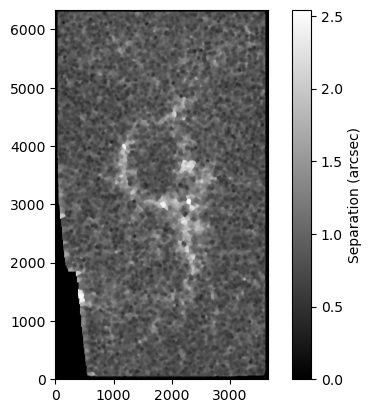

In [22]:
grid = np.empty(cutout_405.data.shape)
grid.fill(np.nan)

kdtr = KDTree(data)
seps, inds = kdtr.query(data, k=[5])

data_rounded = np.round(data).astype(int)
data_rounded = np.floor(data).astype(int)

seps_arcsec = (seps * pixel_scale).value

for i in range(len(data_rounded)):
    grid[data_rounded[i, 1], data_rounded[i, 0]] = seps_arcsec[i, 0]

kernel = Gaussian2DKernel(15)
grid = convolve_fft(grid, kernel)
#grid = interpolate_replace_nans(grid, kernel)

im = plt.imshow(grid, origin='lower', cmap='gray')
plt.colorbar(im, label='Separation (arcsec)')
#plt.scatter(data_rounded[:,0], data_rounded[:,1], s=0.1, color='k')

In [29]:
len(cat_use_red.catalog)

27202

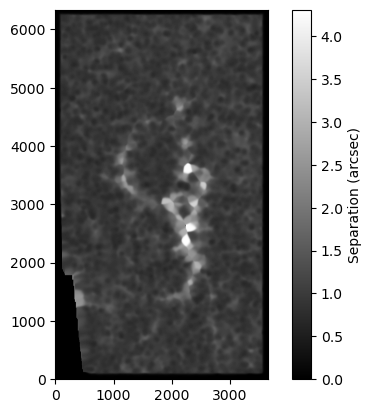

In [24]:
color_cut = 2.0
cat_use_red = JWSTCatalog(cat_filament.catalog[cat_filament.color('f182m', 'f410m') > color_cut])
data_red = np.array(ww.all_world2pix(cat_use_red.coords.ra, cat_use_red.coords.dec, 0)).T

grid_red = np.empty(cutout_405.data.shape)
grid_red.fill(np.nan)

kdtr = KDTree(data_red)
seps, inds = kdtr.query(data_red, k=[5])

data_rounded = np.floor(data_red).astype(int)

seps_arcsec = (seps * pixel_scale).value

for i in range(len(data_rounded)):
    grid_red[data_rounded[i, 1], data_rounded[i, 0]] = seps_arcsec[i, 0]

kernel = Gaussian2DKernel(30)
grid_red = convolve_fft(grid_red, kernel)
#grid = interpolate_replace_nans(grid, kernel)

im = plt.imshow(grid_red, origin='lower', cmap='gray')
#plt.contour(grid, levels=[1.5], colors='r')
plt.colorbar(im, label='Separation (arcsec)')
#plt.scatter(data_rounded[:,0], data_rounded[:,1], s=0.1, color='k')

In [60]:
hdu_stellar_density = fits.PrimaryHDU(5/grid_red**2, header=ww.to_header())
hdu_stellar_density.writeto('/orange/adamginsburg/jwst/cloudc/images/stellar_density.fits', overwrite=True)

/scratch/local/50404825/ipykernel_1288976/4087082843.py:1: RuntimeWarning: divide by zero encountered in divide
  hdu_stellar_density = fits.PrimaryHDU(5/grid_red**2, header=ww.to_header())


In [61]:
data.size

74688

In [62]:
grid.size

23092977

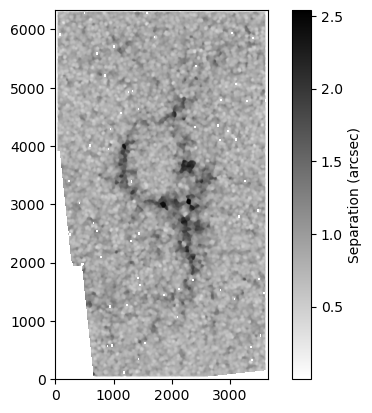

In [63]:
grid[data_405 == 0] = np.nan
grid[np.isnan(data_405)] = np.nan
im = plt.imshow(grid, origin='lower', cmap='gray_r')
plt.colorbar(im, label='Separation (arcsec)')

In [64]:
def percentile_list(data, percentiles=[50, 80, 90]):
    return [np.percentile(data, p) for p in percentiles]

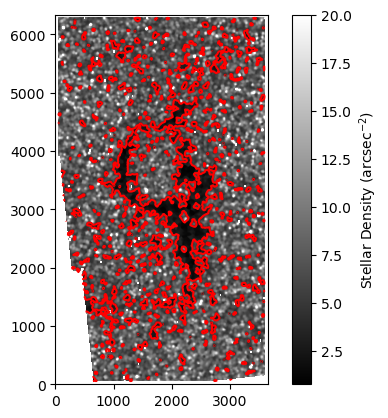

In [70]:
im = plt.imshow(5/grid**2, origin='lower', cmap='gray', vmax=20)
plt.contour(5/grid**2, levels=[4], colors='r')
plt.colorbar(im, label=r'Stellar Density (arcsec$^{-2}$)')

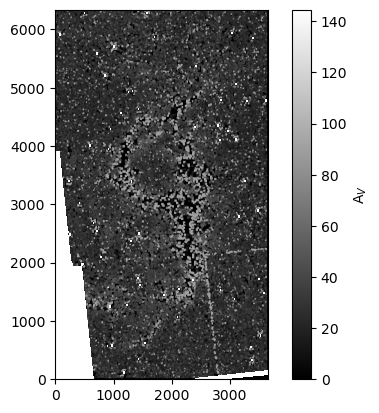

In [38]:
grid_Av = np.empty(cutout_405.data.shape)
grid_Av.fill(np.nan)

kdtr = KDTree(data)
seps, inds = kdtr.query(data, k=[2])

data_rounded = np.round(data).astype(int)
data_rounded = np.floor(data).astype(int)

#seps_arcsec = (seps * pixel_scale).value
Av = np.array(cat_filament.get_Av_182410())
too_red = np.isnan(np.array(cat_filament.band('f182m'))) & ~np.isnan(np.array(cat_filament.band('f410m')))
Av[too_red] = 90

for i in range(len(data_rounded)):
    grid_Av[data_rounded[i, 1], data_rounded[i, 0]] = Av[i] #seps_arcsec[i, 0]

kernel = Gaussian2DKernel(5)
grid_Av = convolve_fft(grid_Av, kernel, nan_treatment='interpolate')
#grid_Av = interpolate_replace_nans(grid_Av, kernel)
grid_Av[data_405 == 0] = np.nan
#grid_Av[np.isnan(data_405)] = np.nan

im = plt.imshow(grid_Av, origin='lower', cmap='gray', vmin=0)#, vmax=60)
plt.colorbar(im, label='A$_V$')
#plt.scatter(data_rounded[:,0], data_rounded[:,1], s=0.1, color='k')

Text(0.5, 1.0, 'Color Cut = 1.5')

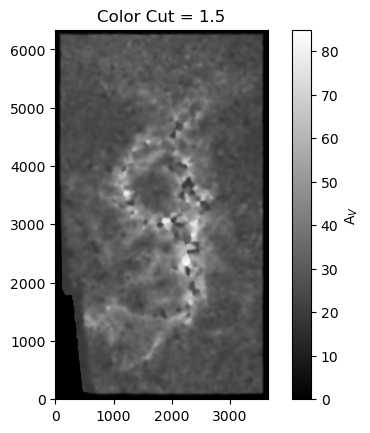

In [39]:
# Remove Foreground Stars
color_cut = 1.5
cat_use_red = JWSTCatalog(cat_filament.catalog[cat_filament.color('f182m', 'f410m') > color_cut])

grid_Av_red = np.empty(cutout_405.data.shape)
grid_Av_red.fill(np.nan)

data_red = np.array(ww.all_world2pix(cat_use_red.coords.ra, cat_use_red.coords.dec, 0)).T

kdtr = KDTree(data_red)
seps, inds = kdtr.query(data_red, k=[2])

data_rounded = np.round(data_red).astype(int)
data_rounded = np.floor(data_red).astype(int)

Av_red = np.array(cat_use_red.get_Av_182410())
too_red = np.isnan(np.array(cat_use_red.band('f182m'))) & ~np.isnan(np.array(cat_use_red.band('f410m')))
Av_red[too_red] = 90

for i in range(len(data_rounded)):
    grid_Av_red[data_rounded[i, 1], data_rounded[i, 0]] = Av_red[i] #seps_arcsec[i, 0]

kernel = Gaussian2DKernel(30)
grid_Av_red = convolve_fft(grid_Av_red, kernel, nan_treatment='interpolate')
#grid_Av_red = interpolate_replace_nans(grid_Av_red, kernel)

im = plt.imshow(grid_Av_red, origin='lower', cmap='gray', vmin=0)#, vmax=60)
plt.colorbar(im, label='A$_V$')
plt.title(f'Color Cut = {color_cut}')

In [23]:
# Remove Foreground Stars
color_cut = 2.0
cat_use_red = JWSTCatalog(cat_filament.catalog[cat_filament.color('f182m', 'f410m') > color_cut])

grid_Av_red = np.empty(cutout_405.data.shape)
grid_Av_red.fill(np.nan)

data_red = np.array(ww.all_world2pix(cat_use_red.coords.ra, cat_use_red.coords.dec, 0)).T

kdtr = KDTree(data_red)
seps, inds = kdtr.query(data_red, k=[2])
seps_arcsec = (seps * pixel_scale).value

data_rounded = np.round(data_red).astype(int)
data_rounded = np.floor(data_red).astype(int)

Av_red = np.array(cat_use_red.get_Av_182410())
too_red = np.isnan(np.array(cat_use_red.band('f182m'))) & ~np.isnan(np.array(cat_use_red.band('f410m')))
Av_ = Av_red
Av_red[too_red] = 90

for i in range(len(data_rounded)):
    grid_Av_red[data_rounded[i, 1], data_rounded[i, 0]] = Av_red[i] #seps_arcsec[i, 0]

kernel = Gaussian2DKernel(30)
grid_Av_red = convolve_fft(grid_Av_red, kernel, nan_treatment='interpolate')
#grid_Av_red = interpolate_replace_nans(grid_Av_red, kernel)
#grid_Av_red[data_405 == 0] = np.nan
#grid_Av_red[grid_Av_red == 0] = np.nan

im = plt.imshow(grid_Av_red, origin='lower', cmap='gray', vmin=0)#, vmax=60)
plt.colorbar(im, label='A$_V$')
plt.title(f'Color Cut = {color_cut}')

: 

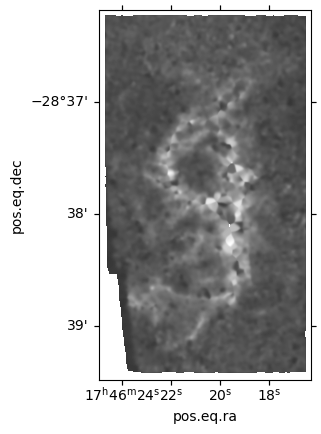

In [ ]:
grid_Av_red[data_405 == np.nan] = np.nan
grid_Av_red[grid_Av_red == 0] = np.nan
grid_Av_red[grid_Av_red <= 15] = np.nan

ax = plt.subplot(projection=ww)
im = plt.imshow(grid_Av_red, origin='lower', cmap='gray', vmin=0)#, vmax=60)
#plt.contour(grid_Av_red, levels=[30], colors='r')

In [22]:
grid_N = np.nansum(grid_Av_red) * 2*10**21 * u.cm**-2
pixel_area_physical = (ww.proj_plane_pixel_scales()[0] * 5 * u.kpc).to(u.cm, u.dimensionless_angles())**2
(grid_N * pixel_area_physical * 2.8*u.u).to(u.Msun)

<Quantity 16508.11658016 solMass>

In [23]:
0.2*10**22

2e+21

(0.0, 100.0)

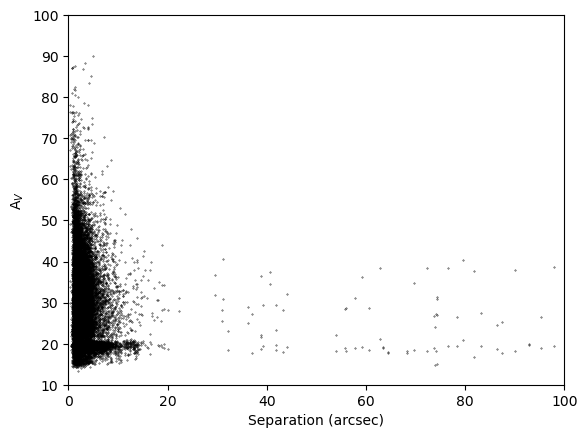

In [24]:
plt.scatter(1/seps_arcsec, Av_, s=0.1, color='k')
plt.xlabel('Separation (arcsec)')
plt.ylabel('A$_V$')
plt.ylim(10, 100)
plt.xlim(0, 100)

Text(0, 0.5, 'A$_V$')

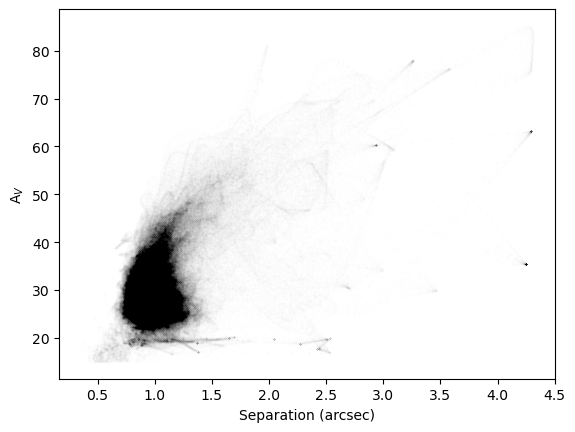

In [31]:
plt.scatter(grid_red[::5,::5].flatten(), grid_Av_red[::5,::5].flatten(), s=0.1, color='k', alpha=0.01)
plt.xlabel('Separation (arcsec)')
plt.ylabel('A$_V$')
# relationship between Av and local separation
# lower limit on separation for a given Av, where stellar density drops below some level, 
# assume the Av measurements are only from foreground stars, replace extinction with extrapolated

(20.0, 90.0)

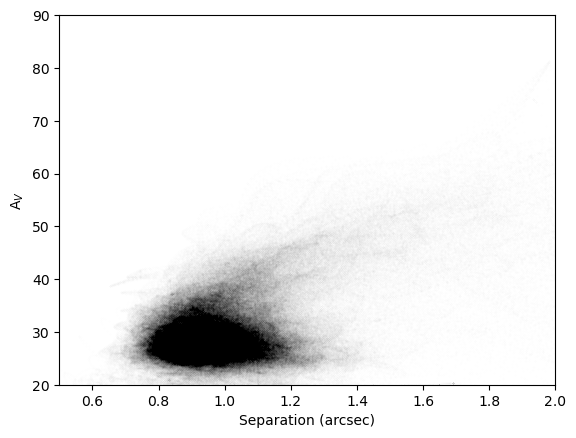

In [35]:
plt.scatter(grid_red[::5,::5].flatten(), grid_Av_red[::5,::5].flatten(), s=0.1, color='k', alpha=0.01)
plt.xlabel('Separation (arcsec)')
plt.ylabel('A$_V$')
# relationship between Av and local separation
# lower limit on separation for a given Av, where stellar density drops below some level, 
# assume the Av measurements are only from foreground stars, replace extinction with extrapolated
plt.xlim(0.5, 2)
plt.ylim(20, 90)

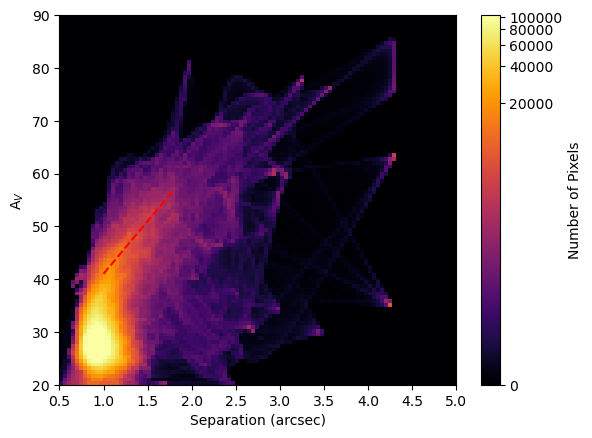

In [27]:
binsx = np.linspace(0.5, 5, 100)
binsy = np.linspace(20, 90, 100)

h,_,__ = np.histogram2d(grid_red.flatten(), grid_Av_red.flatten(), bins=[binsx, binsy])
norm = simple_norm(h, 'log', percent=99)

im = plt.imshow(h.T, origin='lower', aspect='auto', extent=[binsx[0], binsx[-1], binsy[0], binsy[-1]], norm=norm, cmap='inferno')
plt.plot([1, 1.8], [41, 57], 'r--')

plt.xlabel('Separation (arcsec)')
plt.ylabel('A$_V$')
plt.colorbar(im, label='Number of Pixels')

/scratch/local/50404825/ipykernel_1327129/1191710028.py:4: RuntimeWarning: divide by zero encountered in divide
  h,_,__ = np.histogram2d(5/grid_red.flatten()**2, grid_Av_red.flatten(), bins=[binsx, binsy])


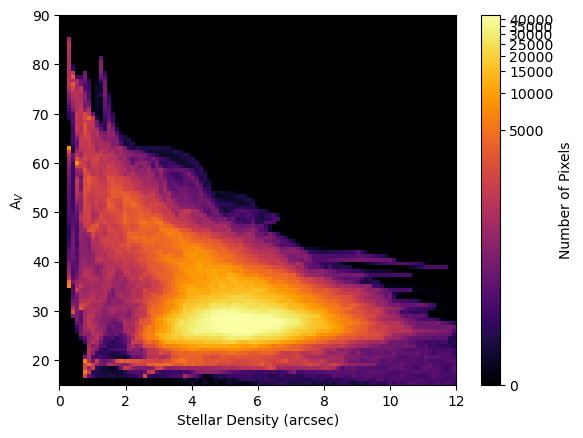

In [32]:
binsx = np.linspace(0, 12, 100)
binsy = np.linspace(15, 90, 100)

h,_,__ = np.histogram2d(5/grid_red.flatten()**2, grid_Av_red.flatten(), bins=[binsx, binsy])
norm = simple_norm(h, 'log', percent=99)

im = plt.imshow(h.T, origin='lower', aspect='auto', extent=[binsx[0], binsx[-1], binsy[0], binsy[-1]], norm=norm, cmap='inferno')
#plt.plot([1, 1.8], [41, 57], 'r--')

plt.xlabel('Stellar Density (arcsec)')
plt.ylabel('A$_V$')
plt.colorbar(im, label='Number of Pixels')

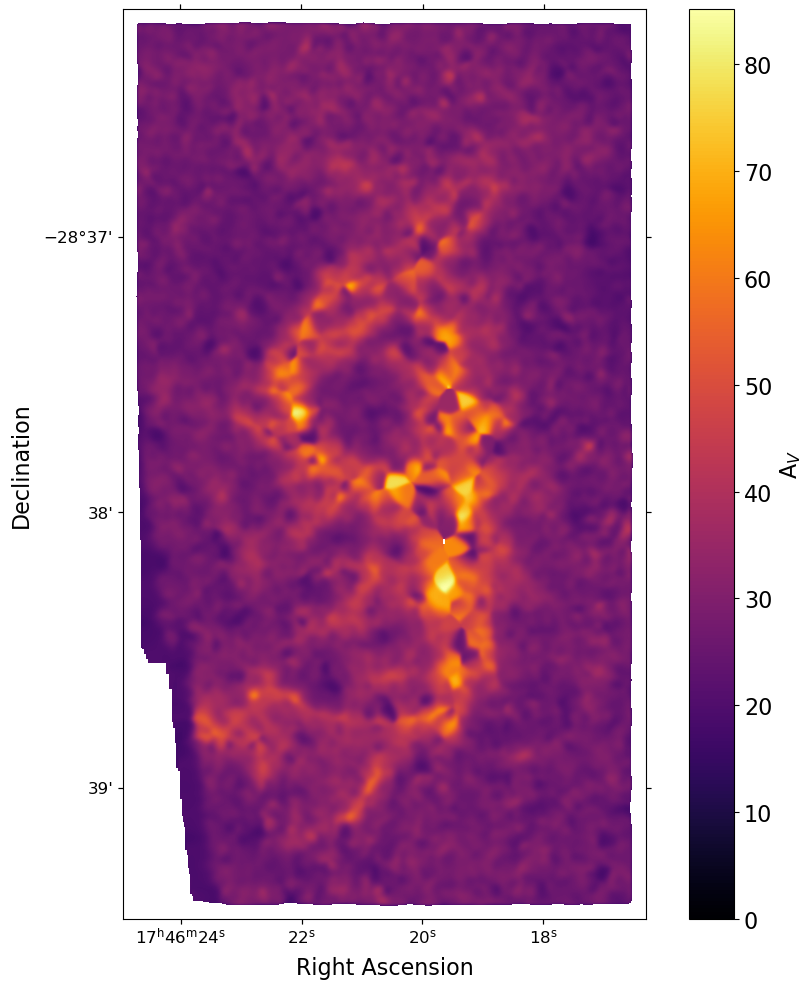

In [30]:
plt.figure(figsize=(10, 10))
plt.style.use('default')
ax = plt.subplot(projection=ww)
grid_Av_red[grid_Av_red == 0] = np.nan
im = plt.imshow(grid_Av_red, origin='lower', cmap='inferno', vmin=0)#, vmax=60)
cbar = plt.colorbar(im, label='A$_V$')
ax.set_xlabel('Right Ascension', fontsize=16)
ax.set_ylabel('Declination', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('A$_V$', fontsize=16)

plt.style.use('default')
plt.tight_layout()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/av_map.png', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/av_map.pdf', bbox_inches='tight')

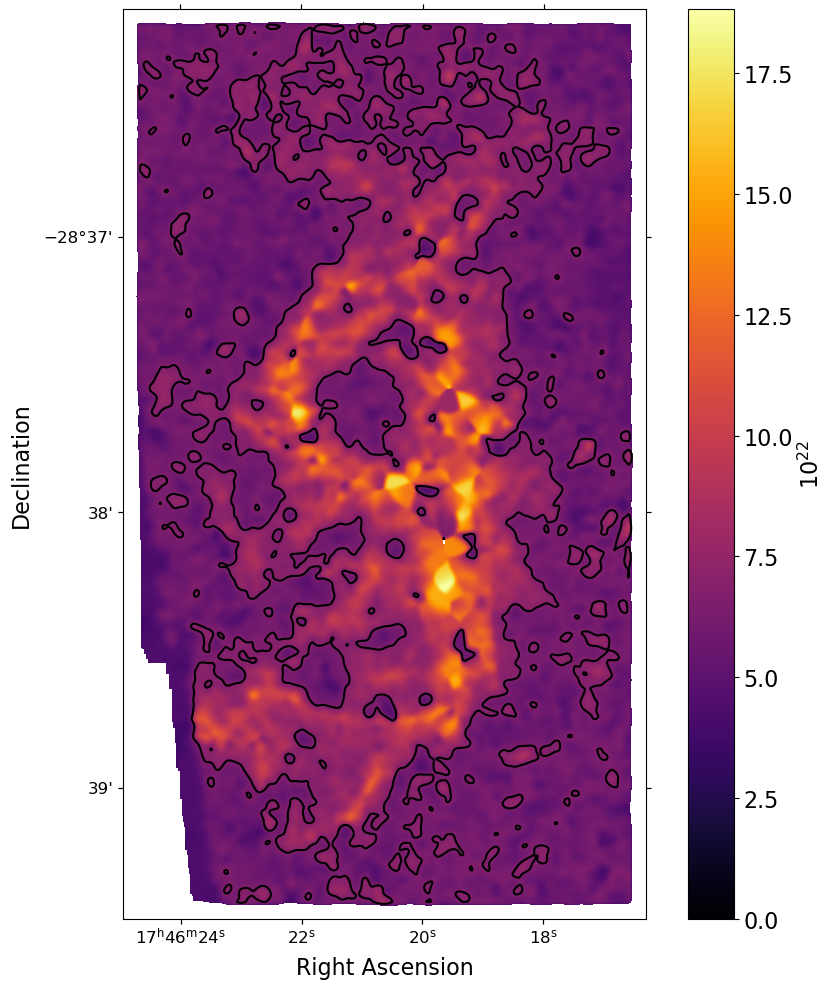

In [34]:
plt.figure(figsize=(10, 10))
plt.style.use('default')
ax = plt.subplot(projection=ww)
grid_Av_red[grid_Av_red == 0] = np.nan
im = plt.imshow(grid_Av_red*0.221, origin='lower', cmap='inferno', vmin=0)#, vmax=60)
cbar = plt.colorbar(im, label='A$_V$')
ax.set_xlabel('Right Ascension', fontsize=16)
ax.set_ylabel('Declination', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.contour(grid_Av_red, levels=[30], colors='black')

cbar.ax.tick_params(labelsize=16) # 0.2*10**22
cbar.ax.set_ylabel('10$^{22}$', fontsize=16)

plt.style.use('default')
plt.tight_layout()
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/N_map.png', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/N_map.pdf', bbox_inches='tight')

In [36]:
hdu_Av = fits.PrimaryHDU(grid_Av_red, header=ww.to_header())
hdu_Av.writeto('/orange/adamginsburg/jwst/cloudc/images/filament_av_map.fits', overwrite=True)

(array([1547526.,  148559.,   82505.,   57185.,   44075.,   35866.,
          30495.,   26851.,   23666.,   21666.,   19910.,   18490.,
          17174.,   16400.,   15596.,   14960.,   14638.,   14069.,
          13738.,   13595.,   13124.,   13199.,   13101.,   13006.,
          12975.,   13266.,   13689.,   14655.,   22727.,   29033.,
          47641.,   91215.,  159513.,  109954.,   95368.,  110888.,
         160236.,  224116.,  304036.,  455274.,  651945.,  833938.,
         968188., 1087646., 1165759., 1197183., 1206828., 1151997.,
        1031586.,  920759.,  781219.,  695160.,  600114.,  518483.,
         475608.,  403518.,  373271.,  348094.,  315211.,  281951.,
         261946.,  236105.,  220907.,  203125.,  191712.,  171821.,
         157467.,  156716.,  145689.,  135379.,  125179.,  119802.,
         114382.,  106319.,  102080.,   96351.,   89462.,   81177.,
          72435.,   68173.,   68161.,   57583.,   53518.,   49684.,
          47588.,   46521.,   45027.,   42268., 

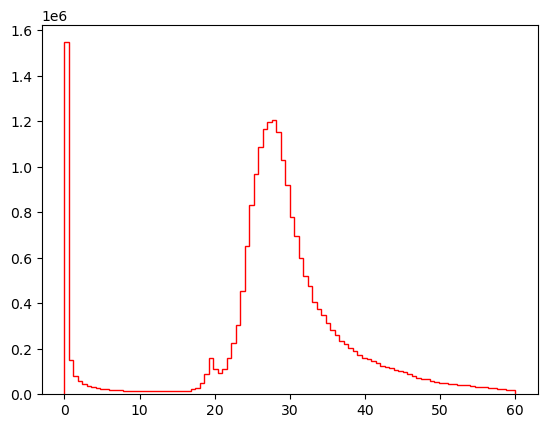

In [63]:
plt.hist(grid_Av_red.flatten(), bins=100, range=(0, 60), histtype='step', color='r', label='Foreground Stars')

## Distance Between Pixel and Nearest Star

In [13]:
color_cut = 2.0
mask = (cat_filament.color('f182m', 'f410m') > color_cut)
mask = np.logical_or(mask, np.isnan(cat_filament.band('f182m')) & ~np.isnan(cat_filament.band('f410m')))
cat_use_red = JWSTCatalog(cat_filament.catalog[mask])
data_red = np.array(ww.all_world2pix(cat_use_red.coords.ra, cat_use_red.coords.dec, 0)).T

kdtr = KDTree(data_red)

In [14]:
kdtr.query([500.5, 500.5], k=[2])

(array([73.3277651]), array([29254]))

In [15]:
#grid = np.empty(cutout_405.data.shape)
#grid.fill(np.nan)
#
#for i in range(grid.shape[0]):
#    for j in range(grid.shape[1]):
#        seps, inds = kdtr.query([j+0.5, i+0.5], k=[2])
#        grid[i, j] = seps[0]


In [16]:
grid = np.empty(cutout_405.data.shape)
grid.fill(np.nan)

grid_coords = np.indices(grid.T.shape)
grid_coords = grid_coords.reshape(2, -1).T

seps, inds = kdtr.query(grid_coords+0.5, k=[5])

#grid = seps[:, 0].reshape(grid.shape)
#grid[grid_coords.reshape(-1, 2)[:, 1], grid_coords.reshape(-1, 2)[:, 0]] = seps[:, 0]

In [17]:
grid_copy = grid.copy()
grid_copy[grid_coords[:, 1], grid_coords[:, 0]] = seps[:, 0]

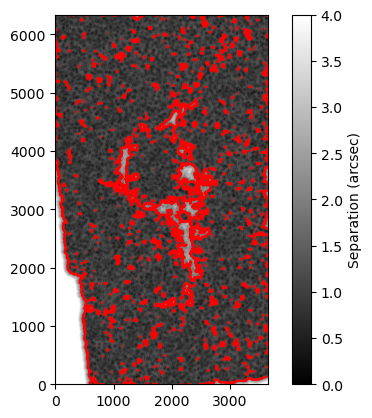

In [18]:
im = plt.imshow((grid_copy*pixel_scale).value, origin='lower', cmap='gray', vmin=0, vmax=4)#, vmin=0, vmax=50)
plt.contour((grid_copy*pixel_scale).value, levels=[1.5], colors='r')
plt.colorbar(im, label='Separation (arcsec)')

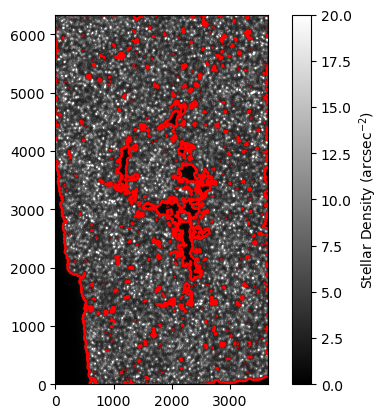

In [22]:
im = plt.imshow(5/(grid_copy*pixel_scale).value**2, origin='lower', cmap='gray', vmin=0, vmax=20)
plt.contour(5/(grid_copy*pixel_scale).value**2, levels=[2], colors='r')
plt.colorbar(im, label=r'Stellar Density (arcsec$^{-2}$)')

# Old Extinction Map

## Remove Foreground and Bright Sources

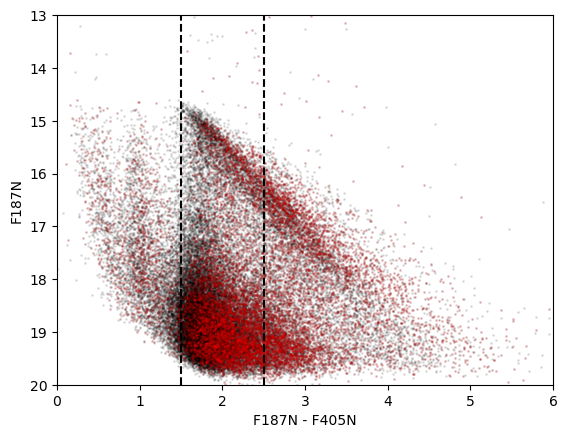

In [12]:
ax = plt.subplot()
cat_use.plot_CMD('f187n', 'f405n', 'f187n', alpha=0.1, s=1, c='k', ax=ax)
cat_filament.plot_CMD('f187n', 'f405n', 'f187n', alpha=0.11, s=1, c='r', ax=ax)
ax.set_xlim(0, 6)
ax.set_ylim(20, 13)
ax.axvline(1.5, color='k', linestyle='--')
ax.axvline(2.5, color='k', linestyle='--')

In [ ]:
mask = (cat_filament.catalog['mag_ab_f187n'] > 15 | ~cat_filament.catalog['mag_ab_f187n'].mask)
mask &= cat_filament.catalog['mag_ab_f182m'] > 15 | ~cat_filament.catalog['mag_ab_f182m'].mask
mask &= cat_filament.catalog['mag_ab_f212n'] > 15 | ~cat_filament.catalog['mag_ab_f212n'].mask
mask &= np.logical_or(cat_filament.catalog['mag_ab_f410m'] > 13.25, ~cat_filament.catalog['mag_ab_f410m'].mask)
mask &= np.logical_or(cat_filament.catalog['mag_ab_f466n'] > 13.25, ~cat_filament.catalog['mag_ab_f466n'].mask)
mask &= np.logical_or(cat_filament.catalog['mag_ab_f405n'] > 13.25, ~cat_filament.catalog['mag_ab_f405n'].mask)
mask &= cat_filament.color('f187n', 'f405n') > 2#1.5# change Av cut 
masked_cat = JWSTCatalog(cat_filament.apply_mask(mask))

(-2.5, 1.5)

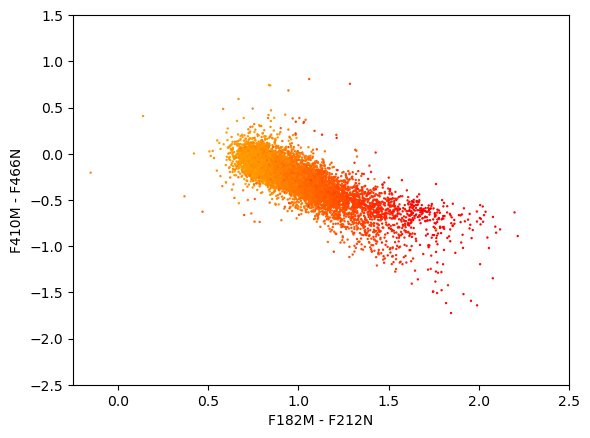

In [14]:
ax2 = plt.subplot(111)
masked_cat.plot_CCD('F182M', 'F212N', 'F410M', 'F466N', c=masked_cat.color('f187n', 'f405n'), ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-2.5, 1.5)
#ax2.legend()

## Making Grid

In [13]:
size = (w, l)
bins_ra = np.arange(0, size[1].to(u.arcsec).value, 1)
bins_dec = np.arange(0, size[0].to(u.arcsec).value, 1)

bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
bins_pix_dec = bins_dec/ww.proj_plane_pixel_scales()[0].to(u.arcsec).value

In [14]:
crds_pix = ww.all_world2pix(masked_cat.ra, masked_cat.dec, 0)

NameError: name 'masked_cat' is not defined

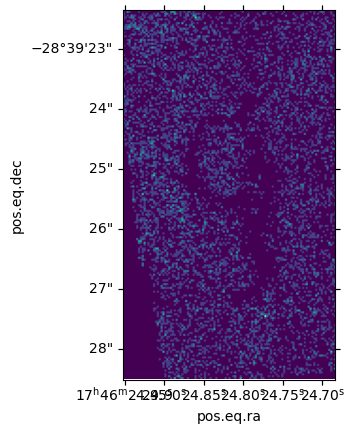

In [17]:
h, xedges, yedges = np.histogram2d(crds_pix[0], crds_pix[1], bins=[bins_pix_ra, bins_pix_dec])
ax = plt.subplot(111, projection=ww)
ax.imshow(h.swapaxes(0,1))

In [18]:
ext_cat = Table()
ext_cat['ra'] = masked_cat.ra
ext_cat['dec'] = masked_cat.dec
ext_cat['x'] = crds_pix[0]
ext_cat['y'] = crds_pix[1]
ext_cat['Av'] = masked_cat.get_Av_182410()
ext_cat['skycoord'] = masked_cat.catalog['skycoord_ref']
ext_cat['mag_ab_f187n'] = masked_cat.catalog['mag_ab_f187n']
ext_cat['mag_ab_f182m'] = masked_cat.catalog['mag_ab_f182m']
ext_cat['mag_ab_f212n'] = masked_cat.catalog['mag_ab_f212n']
ext_cat['mag_ab_f410m'] = masked_cat.catalog['mag_ab_f410m']
ext_cat['mag_ab_f466n'] = masked_cat.catalog['mag_ab_f466n']
ext_cat['mag_ab_f405n'] = masked_cat.catalog['mag_ab_f405n']

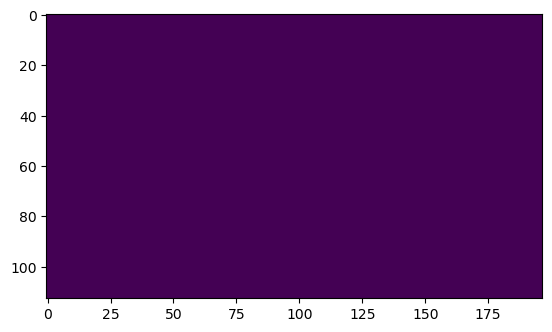

In [19]:
h_0 = np.zeros_like(h)
plt.imshow(h_0)

In [20]:
naxis1 = h_0.shape[0]
naxis2 = h_0.shape[1]

for i in range(naxis1):
    for j in range(naxis2):
        x = bins_pix_ra[i]+0.5
        y = bins_pix_dec[j]+0.5

        ra, dec = ww.wcs_pix2world(x, y, 0)

        pos = SkyCoord(ra, dec, unit=(u.deg, u.deg))

        seplimit = 1.5*u.arcsec
        idx = np.where(pos.separation(ext_cat['skycoord']) < seplimit)[0]

        nearest_stars = ext_cat[idx]

        avg_Av = np.mean(nearest_stars['Av'])

        h_0[i, j] = avg_Av

/scratch/local/45159197/ipykernel_2846081/3188155118.py:20: UserWarning: Warning: converting a masked element to nan.
  h_0[i, j] = avg_Av


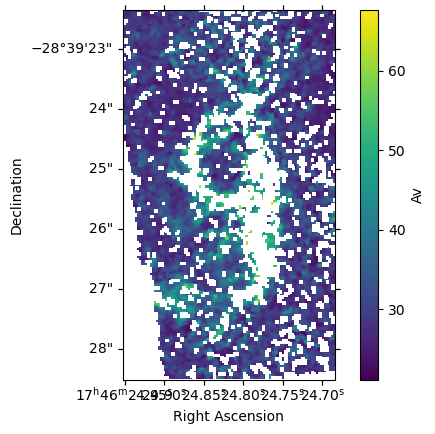

In [21]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(h_0.swapaxes(0,1))
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.colorbar(im, label='Av', ax=ax)

In [48]:
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel

# Create a Gaussian kernel
gauss_kernel = Gaussian2DKernel(1)

# Interpolate the NaN values
h_1 = interpolate_replace_nans(h_0, gauss_kernel)

# swap axes
h_1 = h_1.swapaxes(0,1)

# Calculate Column Density
N = h_1 * 0.2

In [49]:
from scipy.ndimage import zoom

# Calculate the scaling factors
scale_factor_x = ww.array_shape[1] / h_1.shape[1]
scale_factor_y = ww.array_shape[0] / h_1.shape[0]

# Scale up h_1
h_1_scaled = zoom(h_1, (scale_factor_y, scale_factor_x), order=1)  # Using bilinear interpolation (order=1)

# Scale up N
N_scaled = zoom(N, (scale_factor_y, scale_factor_x), order=1)  # Using bilinear interpolation (order=1)

# Verify the new shape
print(h_1_scaled.shape)

(6339, 3643)


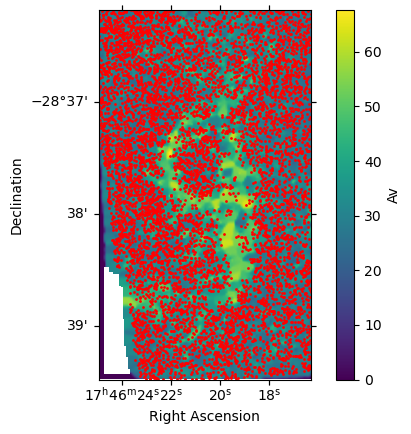

In [24]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(h_1_scaled, origin='lower')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(im, label='Av', ax=ax)
ax.scatter(ext_cat['x'], ext_cat['y'], c='r', s=1)

In [26]:
plt.style.use('dark_background')

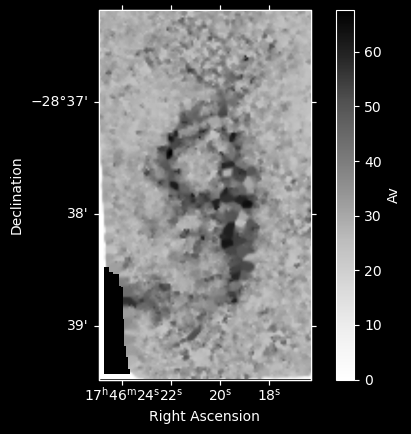

In [50]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(h_1_scaled, origin='lower', cmap='Greys')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(im, label='Av', ax=ax)
#ax.scatter(ext_cat['x'], ext_cat['y'], c='r', s=1)

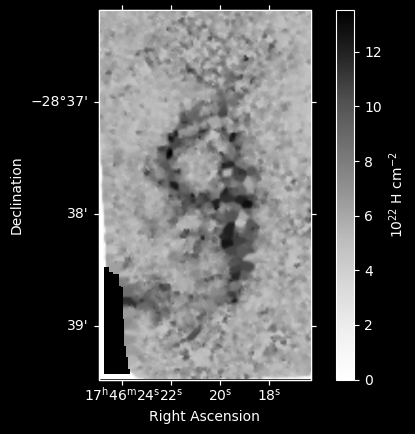

In [51]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(N_scaled, origin='lower', cmap='Greys')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(im, label=r'10$^{22}$ H cm$^{-2}$', ax=ax)
#ax.scatter(ext_cat['x'], ext_cat['y'], c='r', s=1)

In [25]:
ext_cat['Av_measured'] = np.nan
for i in range(len(ext_cat)):
    x, y = ext_cat['x'][i], ext_cat['y'][i]
    x = int(x)
    y = int(y)
    ext_cat['Av_measured'][i] = h_1_scaled[y, x]

In [53]:
ext_cat

<Table length=7345>
        ra                 dec         ...    mag_ab_f405n       Av_measured    
       deg                 deg         ...                                      
     float64             float64       ...      float64            float64      
------------------ ------------------- ... ------------------ ------------------
 266.6032475263581 -28.603743708232592 ...  16.98584289764475  25.56829809667931
 266.6028100809035 -28.607831632980137 ... 14.253229694716154 31.673721655074417
 266.6027563658287 -28.608466155529275 ... 13.826535586584683 30.068485244554132
266.60319369666445 -28.604134497426564 ... 17.331992609820688  28.52289974106716
266.60310890176356  -28.60495001414533 ... 14.848620046582486 29.248226099034156
 266.6027648673514   -28.6081252226168 ...  16.40346335450295 30.905188071242584
 266.6029936956481  -28.60574460659813 ...  17.01594351548334 28.104252182261654
266.60300334672377   -28.6055803737722 ... 16.412782791008944 28.634223301775286
266.60259607768177  -28.60930754279462 ...  16.22854370988477 31.547209509599718
               ...                 ... ...                ...                ...
266.60375212893507  -28.62203591832232 ... 17.047309708079755 23.222505750149057
266.60354587526894  -28.62345596541156 ... 17.137884462755874  22.26917900481657
 266.6034196880606 -28.623011066592348 ...   17.1470277724254 23.339015181511996
  266.603744716822 -28.620050073900707 ... 14.907182008030471  29.75149802462402
 266.6037015233609 -28.617988414593444 ... 16.866570772505586 28.108098111655387
 266.5947713853357  -28.60323671311492 ... 17.252261869360954  29.21260663917003
 266.5695196912989 -28.616866700479605 ... 13.659857610386094   25.4594856407626
266.57061351564835 -28.614346462074643 ... 17.084228512586066  25.73001552258891
266.59914145777356 -28.604413842148027 ...  16.34707023315843 27.904882306558243

In [55]:
ext_cat['skycoord_ref'] = ext_cat['skycoord']
tabl_cat = JWSTCatalog(ext_cat)